<a href="https://colab.research.google.com/github/KunAn89/Modeling_Risk/blob/main/Modeling_Market_Risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

VaR
Value at Risk

Colab Running Information

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


Package

In [ ]:
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.7/981.7 kB 11.5 MB/s eta 0:00:00


In [ ]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gspread
import matplotlib.cm as cm
import seaborn as sns
import networkx as nx
from scipy.optimize import minimize
from scipy.stats import t

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Input, Dense, LSTM, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Reshape

from sklearn.preprocessing import MinMaxScaler

from scipy.stats import norm, t
from arch import arch_model

from google.colab import auth
from google.auth import default

Data Reading

In [ ]:
#Setup for Google Sheets API
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

In [ ]:
def get_sheet_data(spreadsheet_name, worksheet_index=0):
    spreadsheet = gc.open(spreadsheet_name)
    worksheet = spreadsheet.get_worksheet(worksheet_index)
    data = worksheet.get_all_values()
    df = pd.DataFrame(data)
    df.columns = df.iloc[0]
    df = df.drop(0)
    df['Date'] = df['Date'].str.split().str[0]
    df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y').dt.date
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
    return df

In [ ]:
sheet_names = ["META", "MSFT", "NFLX"]

dataframes = [get_sheet_data(name) for name in sheet_names]

combined_df = pd.concat(dataframes, ignore_index=True)

for df in dataframes:
    print(df.head())

0        Date    Open    High     Low   Close    Volume
1  2022-01-03   338.3  341.08  337.19  338.54  14562849
2  2022-01-04  339.95  343.09  331.87  336.53  15997974
3  2022-01-05  333.02  335.76  323.84  324.17  20564521
4  2022-01-06  322.82  339.17  322.72  332.46  27962809
5  2022-01-07  332.74     337  328.88  331.79  14722020
0        Date    Open    High     Low   Close    Volume
1  2022-01-03  335.35     338  329.78  334.75  28918013
2  2022-01-04  334.83   335.2  326.12  329.01  32674306
3  2022-01-05  325.86  326.07  315.98  316.38  40054327
4  2022-01-06  313.15   318.7  311.49  313.88  39646148
5  2022-01-07  314.15   316.5  310.09  314.04  32720018
0        Date    Open    High     Low   Close   Volume
1  2022-01-03  605.61  609.99  590.56  597.37  3068808
2  2022-01-04  599.91  600.41   581.6  591.15  4393135
3  2022-01-05     592  592.84  566.88  567.52  4148749
4  2022-01-06  554.34  563.36  542.01  553.29  5711795
5  2022-01-07  549.46  553.43  538.22  541.06  338287

Test Data

In [ ]:
sheet_names_test = ["Test Data"]

dataframes_test = [get_sheet_data(name) for name in sheet_names_test]

combined_df = pd.concat(dataframes_test, ignore_index=True)

for df in dataframes_test:
    print(df.head())

0        Date Open   High     Low  Close Volume
1  2022-01-04  616    622  610.05  614.0  10779
2  2022-01-05  614  615.6  611.52  614.0   5924
3  2022-01-06  614  615.6     610  614.0   7015
4  2022-01-07  625  615.6     611  612.0  25109
5  2022-01-10  625    612     605  612.0   7741


Visulization

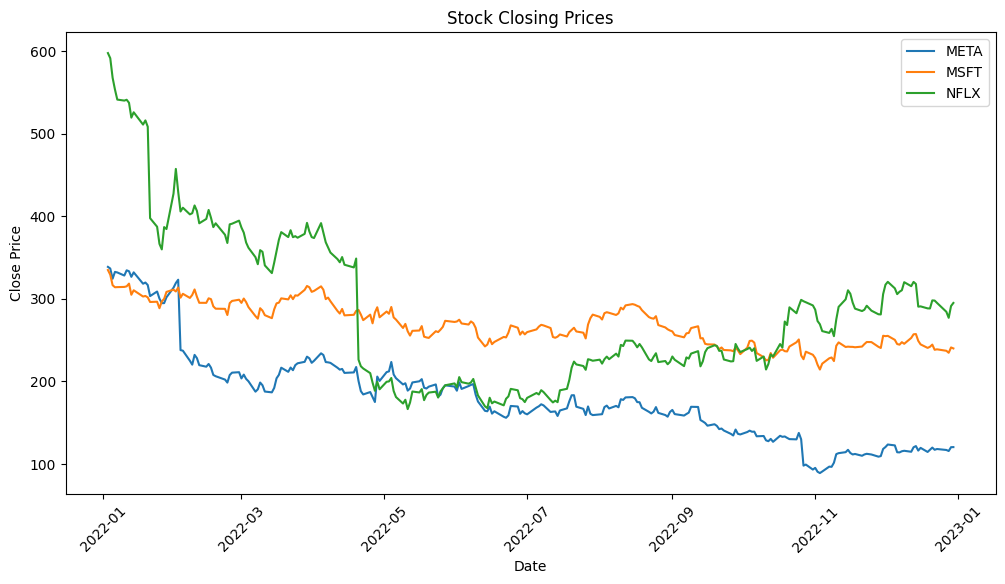

In [ ]:
dataframes_forSeen = {name: get_sheet_data(name) for name in sheet_names}
plt.figure(figsize=(12, 6))
for name, df in dataframes_forSeen.items():
    plt.plot(df['Date'], df['Close'], label=name)

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Closing Prices')
plt.legend()
plt.xticks(rotation=45)
plt.show()

Data Set Reinforcement

In [ ]:
def bootstrap_data(df, n_bootstraps=1):
    bootstrap_samples = []
    for _ in range(n_bootstraps):
        sample = df.sample(n=len(df), replace=True)  # Allow Repeat
        bootstrap_samples.append(sample)
    return bootstrap_samples

In [ ]:
# Assuming 'dataframes' is your list of original dataframes
bootstraped_dataframes = [bootstrap_data(df) for df in dataframes]

# Iterating through each bootstrap sample for each original dataframe
for i, bootstrapped_dfs in enumerate(bootstraped_dataframes):
    print(f"Original DataFrame {i}:")
    for j, df_sample in enumerate(bootstrapped_dfs):
        print(f"Bootstrap Sample {j + 1} Head:")
        print(df_sample.head())
        print()  # Just for a blank line between samples

Original DataFrame 0:
Bootstrap Sample 1 Head:
0          Date    Open    High     Low   Close    Volume
59   2022-03-28  222.13  224.04  219.54  223.59  26224141
236  2022-12-08  116.39  117.34  114.59  115.33  30619418
139  2022-07-22  173.07   175.6  168.41  169.27  42583916
29   2022-02-11  228.46  230.42  218.77  219.55  46156943
224  2022-11-21  111.52  112.37  109.19  109.86  24351074

Original DataFrame 1:
Bootstrap Sample 1 Head:
0          Date    Open    High     Low   Close    Volume
105  2022-06-02  264.45  274.65   261.6  274.58  44008209
53   2022-03-18  295.37     301  292.73  300.43  43390625
150  2022-08-08  284.05  285.92  279.32  280.32  18757818
155  2022-08-15     291  294.18  290.11  293.47  18085654
177  2022-09-15  249.77   251.4  244.02  245.38  31530948

Original DataFrame 2:
Bootstrap Sample 1 Head:
0          Date    Open    High     Low   Close    Volume
78   2022-04-25  213.81  216.66  204.51  209.91  28152045
8    2022-01-12  544.27  544.27  532.02  537.

In [ ]:
def prepare_data_for_lstm(df, feature_columns, target_column, n_steps):
    """
    Prepares data for LSTM.

    :param df: Input DataFrame.
    :param feature_columns: List of column names to be used as features.
    :param target_column: Name of the target column.
    :param n_steps: Number of time steps to look back for the LSTM.
    :return: Returns input and output data for the LSTM.
    """

    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[feature_columns])

    X, y = [], []

    # Create sequences
    for i in range(n_steps, len(df)):
        X.append(scaled_data[i-n_steps:i, :])
        y.append(scaled_data[i, df.columns.get_loc(target_column)])

    # Convert to arrays and reshape for LSTM
    X, y = np.array(X), np.array(y)

    # LSTM expects input shape of [samples, time steps, features]
    X = np.reshape(X, (X.shape[0], X.shape[1], len(feature_columns)))

    return X, y, scaler

In [ ]:
n_steps = 5  # Use data from the past 5 time points to predict the next time point

In [ ]:
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        LSTM(50),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
lstm_models = []
predictions = []

for df in dataframes:
    X, y, scaler = prepare_data_for_lstm(df=dataframes[0], feature_columns=['Open', 'High', 'Low', 'Close', 'Volume'], target_column='Close', n_steps=n_steps)
    model = build_lstm_model(X.shape[1:])
    model.fit(X, y, epochs=10, batch_size=32)
    lstm_models.append(model)
    predictions.append(model.predict(X))

Epoch 1/10
8/8 [==============================] - 5s 9ms/step - loss: 0.0158
Epoch 2/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0121
Epoch 3/10
8/8 [==============================] - 0s 8ms/step - loss: 0.0111
Epoch 4/10
8/8 [==============================] - 0s 9ms/step - loss: 0.0104
Epoch 5/10
8/8 [==============================] - 0s 8ms/step - loss: 0.0100
Epoch 6/10
8/8 [==============================] - 0s 8ms/step - loss: 0.0099
Epoch 7/10
8/8 [==============================] - 0s 8ms/step - loss: 0.0098
Epoch 8/10
8/8 [==============================] - 0s 8ms/step - loss: 0.0094
Epoch 9/10
8/8 [==============================] - 0s 9ms/step - loss: 0.0093
Epoch 10/10
8/8 [==============================] - 1s 3ms/step
Epoch 1/10
8/8 [==============================] - 4s 9ms/step - loss: 0.0150
Epoch 2/10
8/8 [==============================] - 0s 8ms/step - loss: 0.0125
Epoch 3/10
8/8 [==============================] - 0s 7ms/step - loss: 0.0106
Epoch 4/10
8

GANS

In [ ]:
def build_generator(seq_length, latent_dim, n_features=5):
    input_noise = Input(shape=(latent_dim,))
    x = Dense(128)(input_noise)
    x = LeakyReLU(alpha=0.01)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(seq_length * n_features)(x)  # Adjust the number of units
    x = Reshape((seq_length, n_features))(x)  # Reshape to match the discriminator's input
    return Model(input_noise, x)

In [ ]:
def build_gan(generator, discriminator):
    z = Input(shape=(latent_dim,))
    fake_seq = generator(z)
    discriminator.trainable = False
    validity = discriminator(fake_seq)
    return Model(z, validity)

In [ ]:
def build_discriminator(seq_length, n_features=5):
    seq = Input(shape=(seq_length, n_features))
    x = LSTM(64, return_sequences=True)(seq)
    x = LSTM(64)(x)
    x = Dense(1, activation='sigmoid')(x)
    return Model(seq, x)

In [ ]:
# Function to preprocess and create sequences
def preprocess_and_create_sequences(df, selected_columns, seq_length):
    data = df[selected_columns]

    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    # Create sequences
    def create_sequences(data, seq_length):
        xs, ys = [], []
        for i in range(len(data) - seq_length):
            x = data[i:(i + seq_length)]
            y = data[i + seq_length]
            xs.append(x)
            ys.append(y)
        return np.array(xs), np.array(ys)

    X, y = create_sequences(scaled_data, seq_length)
    return X, y, scaler

# Preprocess each DataFrame and create sequences
latent_dim = 32
seq_length = 60
processed_data = [preprocess_and_create_sequences(df, ['Open', 'High', 'Low', 'Close', 'Volume'], seq_length) for df in dataframes]

In [ ]:
generator = build_generator(seq_length, latent_dim, n_features=5)  # Make sure to match n_features
discriminator = build_discriminator(seq_length, n_features=5)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [ ]:
def train_gan(generator, discriminator, gan, processed_data, epochs, batch_size, latent_dim):
    for data_tuple in processed_data:
        X, y, _ = data_tuple  # Assuming each tuple is (X, y, scaler)
        real = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            # Randomly select real sequences
            idx = np.random.randint(0, X.shape[0], batch_size)
            real_seqs = X[idx]

            # Generate fake sequences
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            fake_seqs = generator.predict(noise)

            # Train discriminator
            d_loss_real = discriminator.train_on_batch(real_seqs, real)
            d_loss_fake = discriminator.train_on_batch(fake_seqs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train generator
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            g_loss = gan.train_on_batch(noise, real)

            # Print progress
            if epoch % 100 == 0:
                print(f"Epoch {epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}] [G loss: {g_loss}]")

In [ ]:
train_gan(generator, discriminator, gan, processed_data, epochs=3, batch_size=32, latent_dim=latent_dim)

1/1 [==============================] - 0s 75ms/step
Epoch 0 [D loss: 0.6866436898708344, acc.: 51.5625] [G loss: 0.6932088732719421]
1/1 [==============================] - 0s 18ms/step
Epoch 0 [D loss: 0.6530214548110962, acc.: 68.75] [G loss: 0.6917662024497986]
1/1 [==============================] - 0s 18ms/step
Epoch 0 [D loss: 0.6559628546237946, acc.: 76.5625] [G loss: 0.6907901763916016]
1/1 [==============================] - 0s 30ms/step


Stat Method

In [ ]:
def calculate_var(df, confidence_level=95):
    # Convert columns to numeric (excluding Date)
    for col in df.columns:
        if col != 'Date':
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Calculate daily returns
    df['Return'] = df['Close'].pct_change()

    # Calculate VaR at the specified confidence level
    var = np.percentile(df['Return'].dropna(), 100 - confidence_level)
    return var

In [ ]:
# Calculating VaR for each stock
for name, df in zip(sheet_names, dataframes):
    var = calculate_var(df)
    print(f"VaR at 95% confidence level for {name}: {var*100:.2f}%")

VaR at 95% confidence level for META: -5.87%
VaR at 95% confidence level for MSFT: -3.85%
VaR at 95% confidence level for NFLX: -5.53%


Historical Historical Maximum Loss

In [ ]:
# Function to calculate VaR by finding the greatest loss
def calculate_VaR_simple_loss(df):
    # Convert columns to numeric (excluding Date)
    for col in df.columns:
        if col != 'Date':
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Calculate daily returns
    df['Return'] = df['Close'].pct_change()

    # Find the greatest loss (minimum return)
    greatest_loss = df['Return'].min()
    return greatest_loss

In [ ]:
# Calculating VaR for each stock by identifying the greatest loss
for name, df in zip(sheet_names, dataframes):
    var = calculate_VaR_simple_loss(df)
    print(f"VaR (greatest loss) for {name}: {var*100:.2f}%")

VaR (greatest loss) for META: -26.39%
VaR (greatest loss) for MSFT: -7.72%
VaR (greatest loss) for NFLX: -35.12%


Time Decay Factor EWMA

In [ ]:
def calculate_VaR_with_time_decay(df, decay_factor=1):
    # Convert columns to numeric (excluding Date)
    for col in df.columns:
        if col != 'Date':
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Calculate daily returns
    df['Return'] = df['Close'].pct_change()

    # Apply exponential weighting
    weights = np.array([decay_factor**i for i in range(len(df))])[::-1]
    weighted_returns = df['Return'] * weights
    weighted_returns /= weights.sum()

    # Find the greatest loss (minimum return) in weighted returns
    greatest_loss = weighted_returns.min()
    return greatest_loss

In [ ]:
# Calculating VaR for each stock by identifying the greatest loss
for name, df in zip(sheet_names, dataframes):
    var = calculate_VaR_with_time_decay(df)
    print(f"VaR (greatest loss) for {name}: {var*100:.2f}%")

VaR (greatest loss) for META: -0.11%
VaR (greatest loss) for MSFT: -0.03%
VaR (greatest loss) for NFLX: -0.14%


In [ ]:
def calculate_VaR_with_time_decay_amend(df, decay_factor=1):
    # Convert columns to numeric (excluding Date)
    for col in df.columns:
        if col != 'Date':
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Calculate daily returns
    df['Return'] = df['Close'].pct_change()

    # Handle NaN values in returns
    df.dropna(subset=['Return'], inplace=True)

    # When decay_factor is 1, use unweighted returns directly
    if decay_factor == 1:
        greatest_loss = df['Return'].min()
    else:
        # Apply exponential weighting
        weights = np.array([decay_factor**i for i in range(len(df))])[::-1]
        weighted_returns = df['Return'] * weights
        weighted_returns /= weights.sum()

        # Find the greatest loss in weighted returns
        greatest_loss = weighted_returns.min()

    return greatest_loss


In [ ]:
# Calculating VaR for each stock by identifying the greatest loss
for name, df in zip(sheet_names, dataframes):
    var = calculate_VaR_with_time_decay_amend(df)
    print(f"VaR (greatest loss) for {name}: {var*100:.2f}%")

VaR (greatest loss) for META: -26.39%
VaR (greatest loss) for MSFT: -7.72%
VaR (greatest loss) for NFLX: -35.12%


CVaR  Expected Shortfall (ES) Tail VaR

In [ ]:
def calculate_CVaR_with_time_decay(df, decay_factor=1, confidence_level=0.95):
    # Convert columns to numeric (excluding Date)
    for col in df.columns:
        if col != 'Date':
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Calculate daily returns
    df['Return'] = df['Close'].pct_change()

    # Apply exponential weighting
    weights = np.array([decay_factor**i for i in range(len(df))])[::-1]
    weighted_returns = df['Return'] * weights
    weighted_returns /= weights.sum()

    # Find the VaR (Value at Risk)
    VaR_threshold = np.percentile(weighted_returns.dropna(), (1 - confidence_level) * 100)

    # Calculate CVaR (Conditional Value at Risk)
    # Only consider the returns that are less than the VaR threshold
    tail_losses = weighted_returns[weighted_returns < VaR_threshold]
    CVaR = tail_losses.mean()  # Conditional VaR is the mean of the losses beyond the VaR threshold

    return CVaR

In [ ]:
# Calculating CVaR for each stock by identifying the conditional mean loss beyond the VaR threshold
for name, df in zip(sheet_names, dataframes):
    cvar = calculate_CVaR_with_time_decay(df)
    print(f"CVaR (conditional mean loss) for {name}: {cvar*100:.2f}%")

CVaR (conditional mean loss) for META: -0.04%
CVaR (conditional mean loss) for MSFT: -0.02%
CVaR (conditional mean loss) for NFLX: -0.04%


Monte Carlo

Individual Stock

In [ ]:
def calculate_stock_returns(initial_value, final_value, days=365):
    """
    Calculate the annual and daily returns of a stock.

    :param initial_value: The initial value of the stock.
    :param final_value: The final value of the stock after a period.
    :param days: The number of days over which the final value is measured. Default is 365 for one year.
    :return: A tuple containing the annual return and daily return as percentages.
    """
    # Calculate annual return
    annual_return = ((final_value - initial_value) / initial_value) * 100

    # Calculate daily return based on the number of days
    daily_return = ((final_value / initial_value) ** (1/days) - 1) * 100

    return annual_return, daily_return

Cal return

In [ ]:
for name, df in zip(sheet_names, dataframes):
    if not df.empty:

        df['Date'] = pd.to_datetime(df['Date'])
        df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

        initial_value = df['Close'].iloc[0]
        final_value = df['Close'].iloc[-1]

        days = (df['Date'].iloc[-1] - df['Date'].iloc[0]).days

        annual_return, daily_return = calculate_stock_returns(initial_value, final_value, days)

        print(name, f"Annual Return: {annual_return:.2f}%, Daily Return: {daily_return:.4f}%")

META Annual Return: -64.24%, Daily Return: -0.2852%
MSFT Annual Return: -27.11%, Daily Return: -0.0878%
NFLX Annual Return: -50.12%, Daily Return: -0.1930%


Normal Dis

In [ ]:
def calculate_VaR_MonteCarlo_Normal(df, days=252, iterations=10000, confidence_level=0.95, plot=False, plot_paths=False):
    # Calculate daily returns
    returns = df['Close'].pct_change().dropna()

    # Fit a GARCH model to estimate volatility
    garch = arch_model(returns, vol='Garch', p=1, q=1)
    model = garch.fit(disp='off')
    forecast = model.forecast(horizon=days)
    vol = np.sqrt(forecast.variance.iloc[-1])

    # Calculate mean return
    mean_return = returns.mean()
    # Simulate returns using the normal distribution
    simulated_returns = np.random.normal(mean_return, vol, (iterations, days))
    # Calculate simulated price changes
    simulated_price_changes = np.exp(simulated_returns) - 1

    # Calculate VaR
    VaR = np.percentile(simulated_price_changes, (1 - confidence_level) * 100)

    if plot:
      # Flatten the array to make it one-dimensional
      flattened_simulated_changes = simulated_price_changes.flatten()
      plt.figure(figsize=(10, 6))
      plt.hist(flattened_simulated_changes, bins=50, alpha=0.7, color='red')
      plt.axvline(x=VaR, color='red', linestyle='--', label=f"VaR at {confidence_level*100}%: {VaR*100:.2f}%")
      plt.title(f"Simulated Price Changes Distribution\nVaR (at {confidence_level*100}%): {VaR*100:.2f}%")
      plt.xlabel('Simulated Price Changes')
      plt.ylabel('Frequency')
      plt.legend()
      plt.grid(True)
      plt.show()

    if plot_paths:
        vol = np.sqrt(forecast.variance.dropna().mean(axis=0))
        simulated_paths = np.zeros((iterations, days))

        for i in range(iterations):
            daily_returns = np.random.normal(mean_return, vol, days)
            simulated_paths[i, :] = np.cumprod(1 + daily_returns) * df['Close'].iloc[-1]

        plt.figure(figsize=(10, 6))
        for i in range(iterations):
            plt.plot(simulated_paths[i], alpha=0.2)

        plt.title(f"Monte Carlo Simulation Paths ({iterations} iterations)")
        plt.xlabel('Days')
        plt.ylabel('Simulated Price')
        plt.grid(True)
        plt.show()

    return VaR

T dis

In [ ]:
def calculate_VaR_MonteCarlo_Advanced(df, days=252, iterations=10000, confidence_level=0.99, scale_factor=10, plot=False, plot_paths=False):
    # Rescaling returns
    returns = df['Close'].pct_change().dropna() * scale_factor

    # GARCH model
    garch = arch_model(returns, vol='Garch', p=1, q=1)
    model = garch.fit(update_freq=10, disp='off')
    forecast = model.forecast(horizon=days)
    vol = np.sqrt(forecast.variance.iloc[-1].iloc[-1]) / scale_factor

    # Fitting t-distribution
    deg_freedom, loc, scale = t.fit(returns)
    simulated_returns = t.rvs(deg_freedom, loc, scale, size=(iterations, days))

    # Simulated price changes
    simulated_price_changes = np.exp(simulated_returns * vol) - 1

    # VaR calculation
    VaR = np.percentile(simulated_price_changes, (1 - confidence_level) * 100)

    if plot:
        flattened_simulated_changes = simulated_price_changes.flatten()
        plt.figure(figsize=(10, 6))
        plt.hist(flattened_simulated_changes, bins=50, alpha=0.7, color='blue')
        plt.axvline(x=VaR, color='red', linestyle='--', label=f"VaR at {confidence_level*100}%: {VaR*100:.2f}%")
        plt.title(f"Simulated Price Changes Distribution\nVaR (at {confidence_level*100}%): {VaR*100:.2f}%")
        plt.xlabel('Simulated Price Changes')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True)
        plt.show()

    if plot_paths:
        vol = np.sqrt(forecast.variance.iloc[-1].iloc[-1]) / scale_factor
        simulated_paths = np.zeros((iterations, days))

        for i in range(iterations):
            daily_returns = t.rvs(deg_freedom, loc, scale, size=days) * vol
            simulated_paths[i, :] = np.cumprod(1 + daily_returns) * df['Close'].iloc[-1]

        plt.figure(figsize=(10, 6))
        for i in range(iterations):
            plt.plot(simulated_paths[i], alpha=0.2)

        plt.title(f"Monte Carlo Simulation Paths ({iterations} iterations)")
        plt.xlabel('Days')
        plt.ylabel('Simulated Price')
        plt.grid(True)
        plt.show()

    return VaR


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001645. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


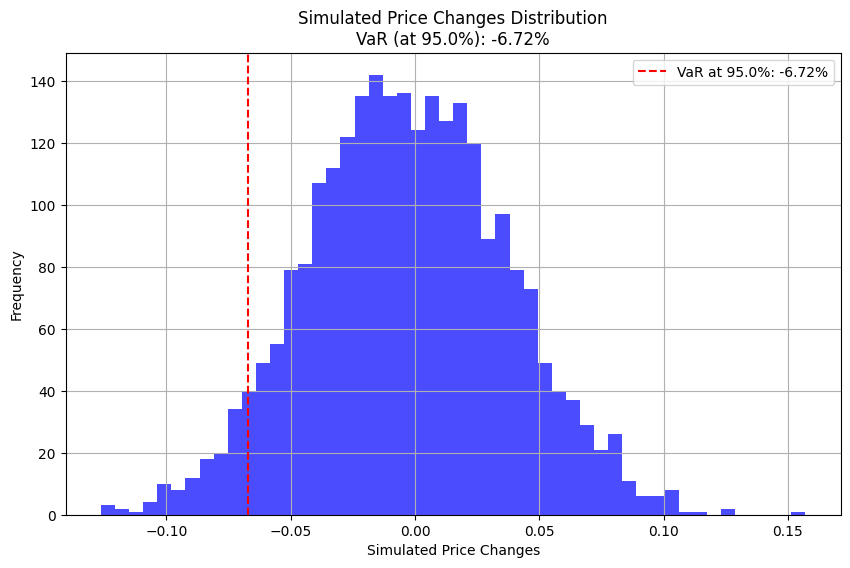

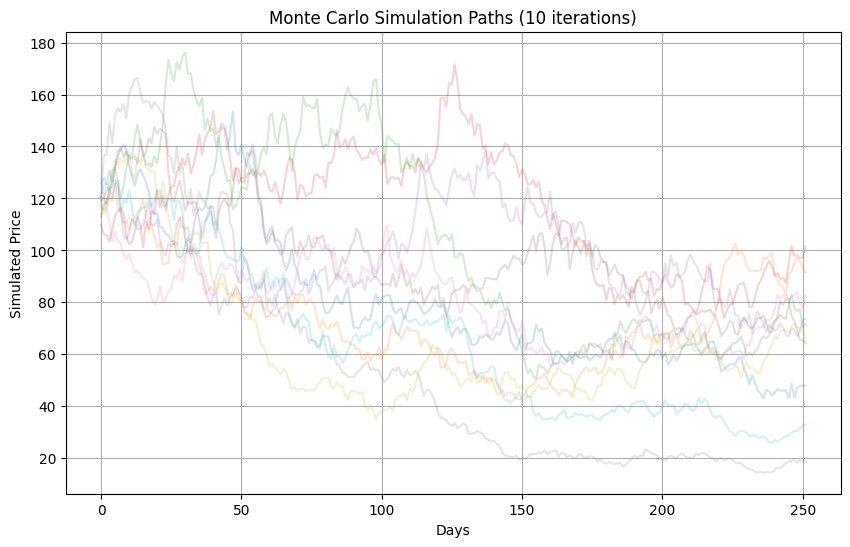

Normal VaR (greatest loss) for META: -6.72%


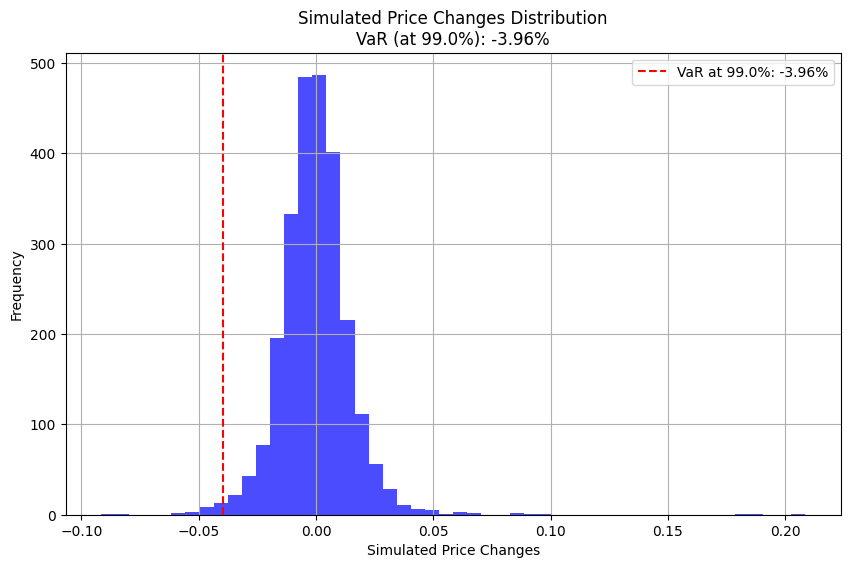

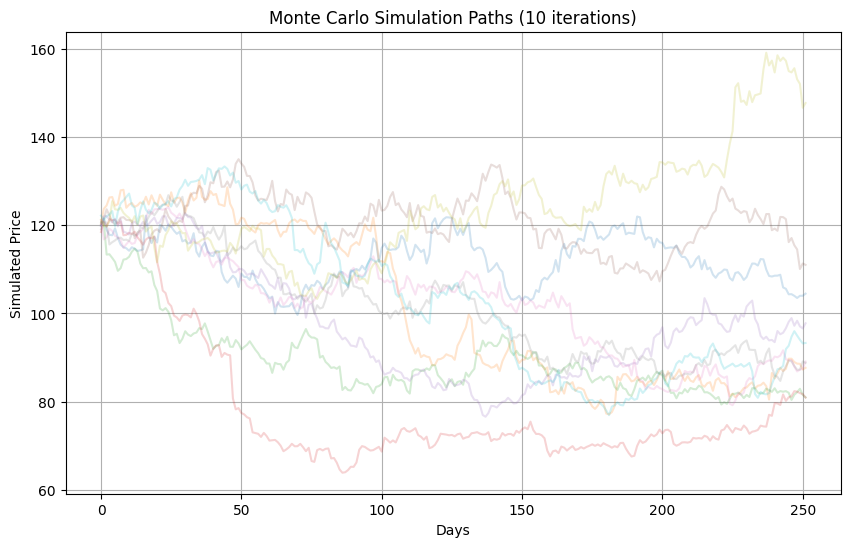

Advanced VaR (greatest loss) for META: -3.96%


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004966. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


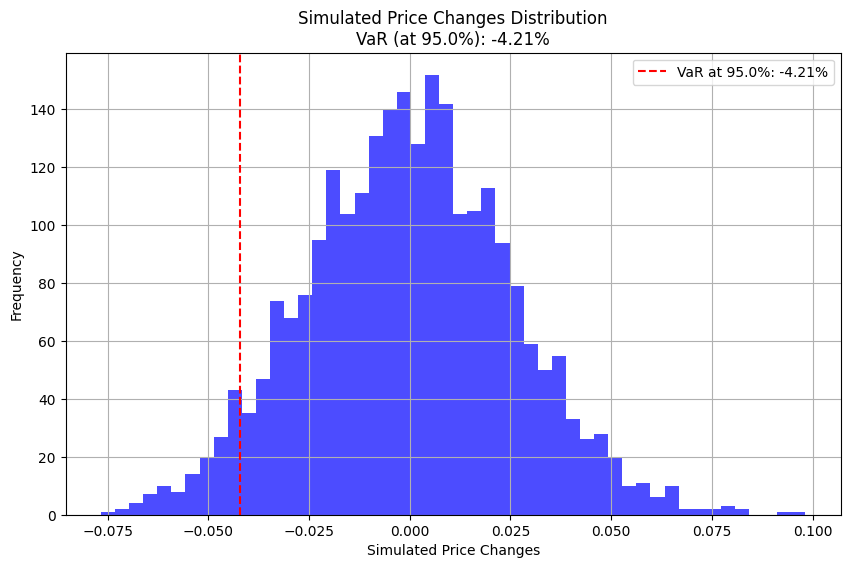

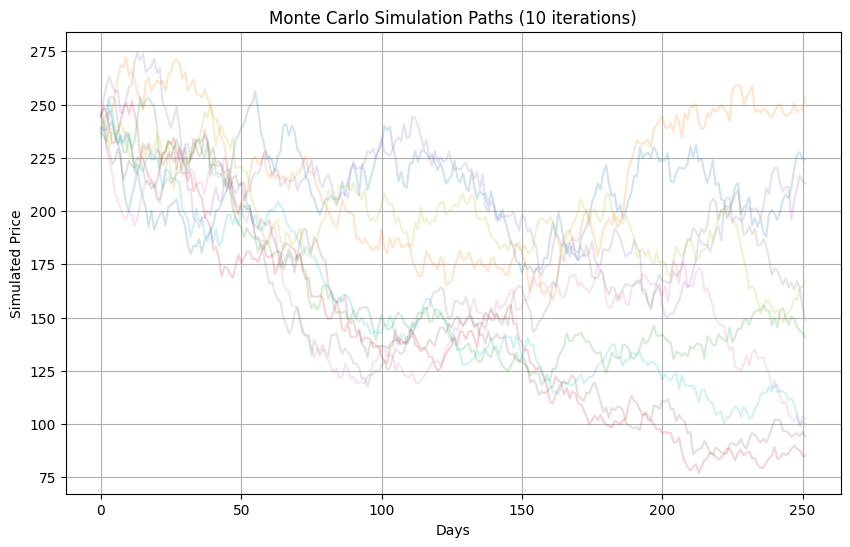

Normal VaR (greatest loss) for MSFT: -4.21%


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04966. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


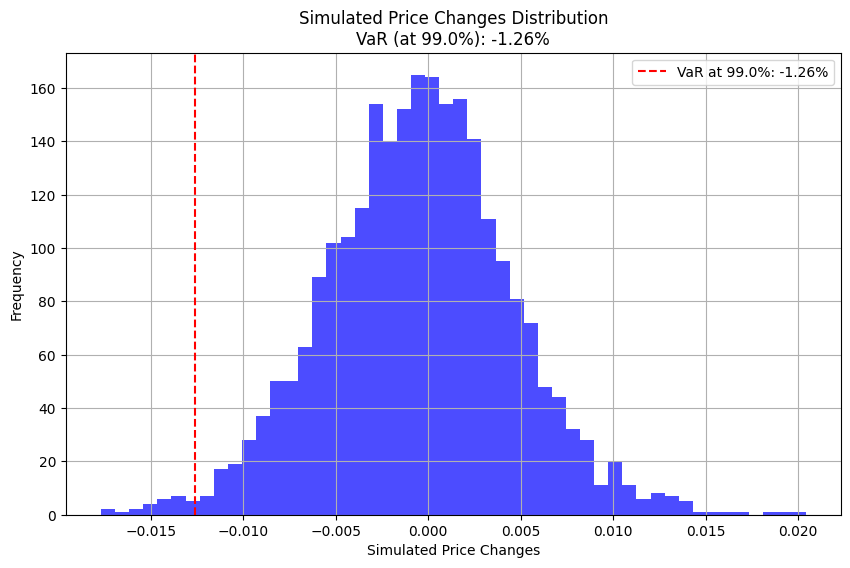

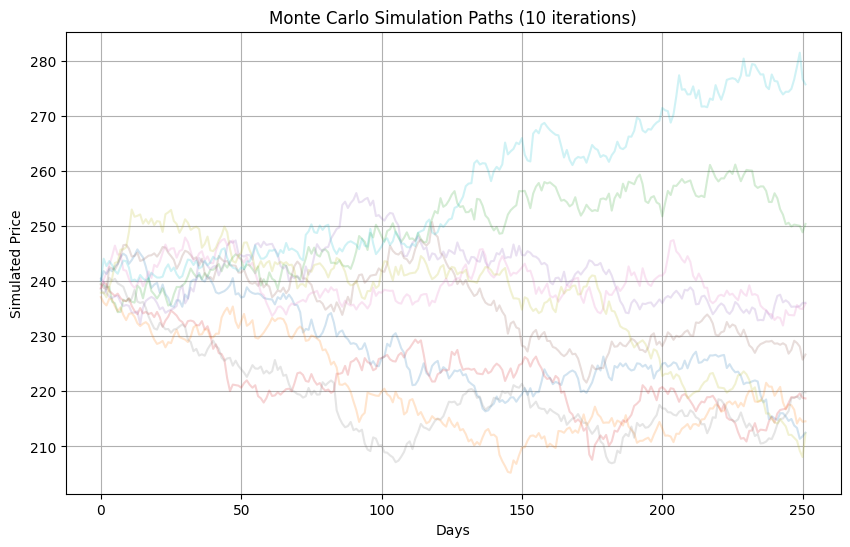

Advanced VaR (greatest loss) for MSFT: -1.26%


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001955. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


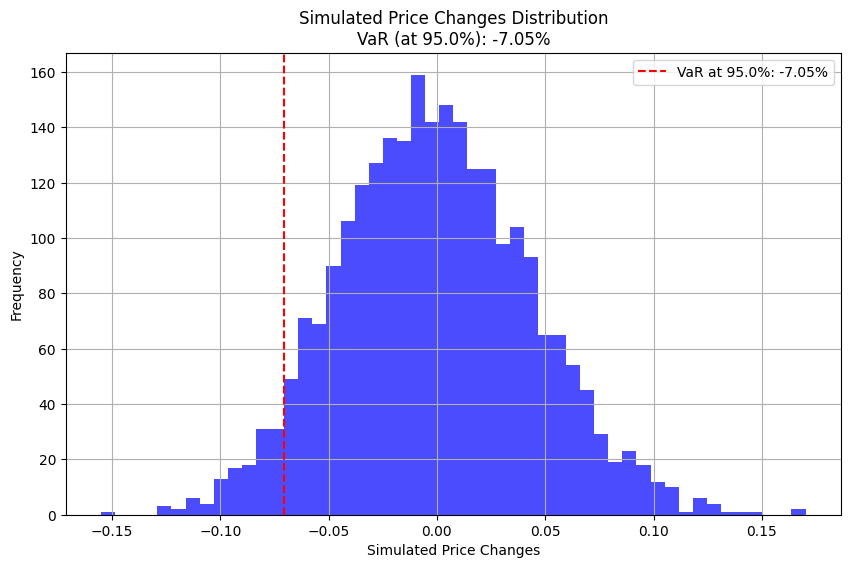

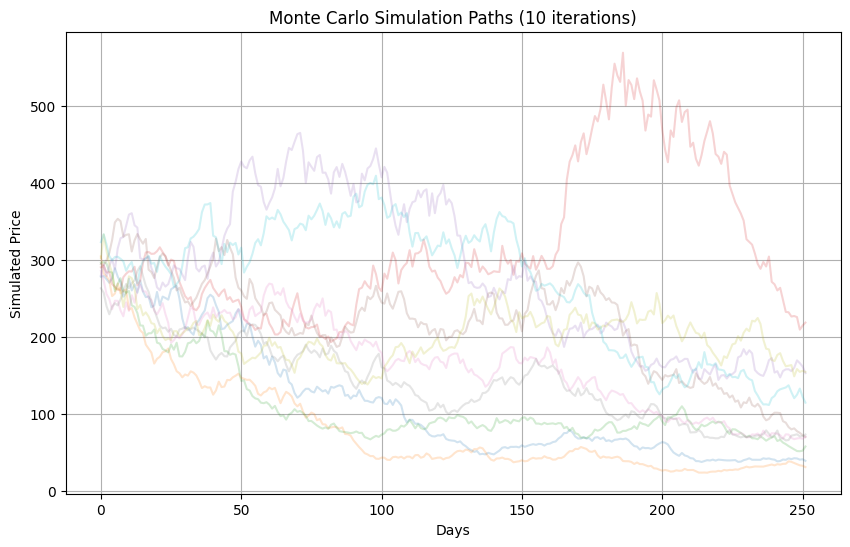

Normal VaR (greatest loss) for NFLX: -7.05%


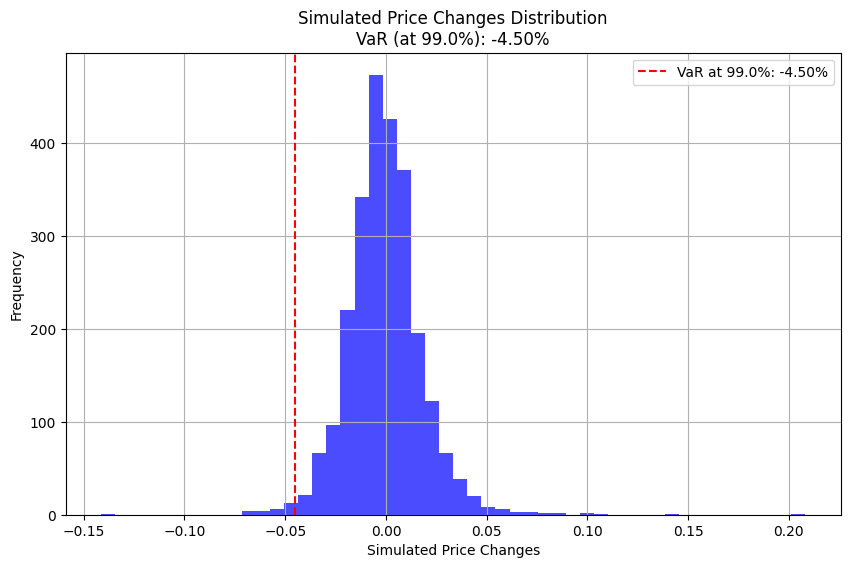

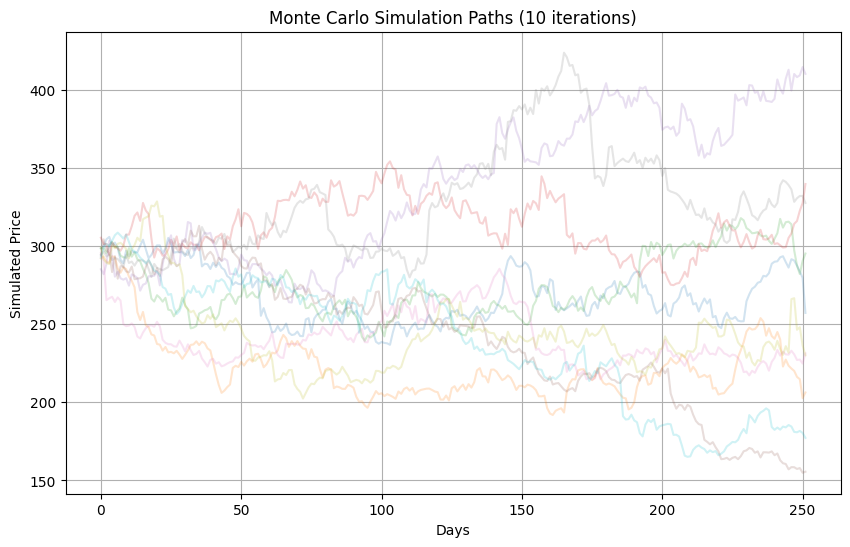

Advanced VaR (greatest loss) for NFLX: -4.50%


In [ ]:
for name, df in zip(sheet_names, dataframes):
    if not df.empty:
        # Call the function for the normal distribution
        var_normal = calculate_VaR_MonteCarlo_Normal(df, days=252, iterations=10, confidence_level=0.95, plot=True, plot_paths=True)
        print(f"Normal VaR (greatest loss) for {name}: {var_normal*100:.2f}%")

        # Call the function for the t-distribution
        var_advanced = calculate_VaR_MonteCarlo_Advanced(df, days=252, iterations=10, confidence_level=0.99, scale_factor=10, plot=True, plot_paths=True)
        print(f"Advanced VaR (greatest loss) for {name}: {var_advanced*100:.2f}%")

In [ ]:
def combined_monte_carlo_simulation(df, days, iterations, confidence_level, plot=True, plot_subset=100):
    # Calculate daily returns
    returns = df['Close'].pct_change().dropna()

    # Estimate parameters
    mean_return = returns.mean()
    vol = returns.std()  # Fixed volatility estimate
    df_param, loc, scale = t.fit(returns)  # Fit t-distribution

    # Simulate price paths
    normal_simulated_returns = norm.rvs(mean_return, vol, (iterations, days))
    t_simulated_returns = t.rvs(df_param, loc, scale, size=(iterations, days))

    initial_price = df['Close'].iloc[-1]
    normal_price_paths = initial_price * np.cumprod(1 + normal_simulated_returns, axis=1)
    t_price_paths = initial_price * np.cumprod(1 + t_simulated_returns, axis=1)

    # Calculate VaR from the final prices
    normal_final_prices = normal_price_paths[:, -1]
    t_final_prices = t_price_paths[:, -1]
    normal_price_VaR = np.percentile(normal_final_prices, (1 - confidence_level) * 100)
    t_price_VaR = np.percentile(t_final_prices, (1 - confidence_level) * 100)

    if plot:
      # Plot the simulated price paths
      plt.figure(figsize=(14, 7))
      subset_indices = np.random.choice(range(iterations), size=plot_subset, replace=False)
      plt.plot(normal_price_paths[subset_indices].T, alpha=0.1, color='blue')
      plt.plot(t_price_paths[subset_indices].T, alpha=0.1, color='red')
      plt.title(f"Combined Monte Carlo Simulation ({iterations} simulations)")
      plt.xlabel('Days')
      plt.ylabel('Simulated Price Paths')
      plt.grid(True)
      plt.show()


      # Plot the histogram of the final simulated prices
      plt.figure(figsize=(10, 6))
      plt.hist(normal_final_prices, bins=50, alpha=0.7, color='blue')
      plt.hist(t_final_prices, bins=50, alpha=0.7, color='red')
      plt.axvline(x=normal_price_VaR, color='navy', linestyle='--', label=f"Normal VaR: {normal_price_VaR:.2f}")
      plt.axvline(x=t_price_VaR, color='darkred', linestyle='--', label=f"t-Distribution VaR: {t_price_VaR:.2f}")
      plt.title(f"Distribution of Simulated Final Prices\nNormal VaR: {normal_price_VaR:.2f}, t-Distribution VaR: {t_price_VaR:.2f}")
      plt.xlabel('Simulated Final Prices')
      plt.ylabel('Frequency')
      plt.legend()
      plt.grid(True)
      plt.show()

      return normal_price_VaR, t_price_VaR

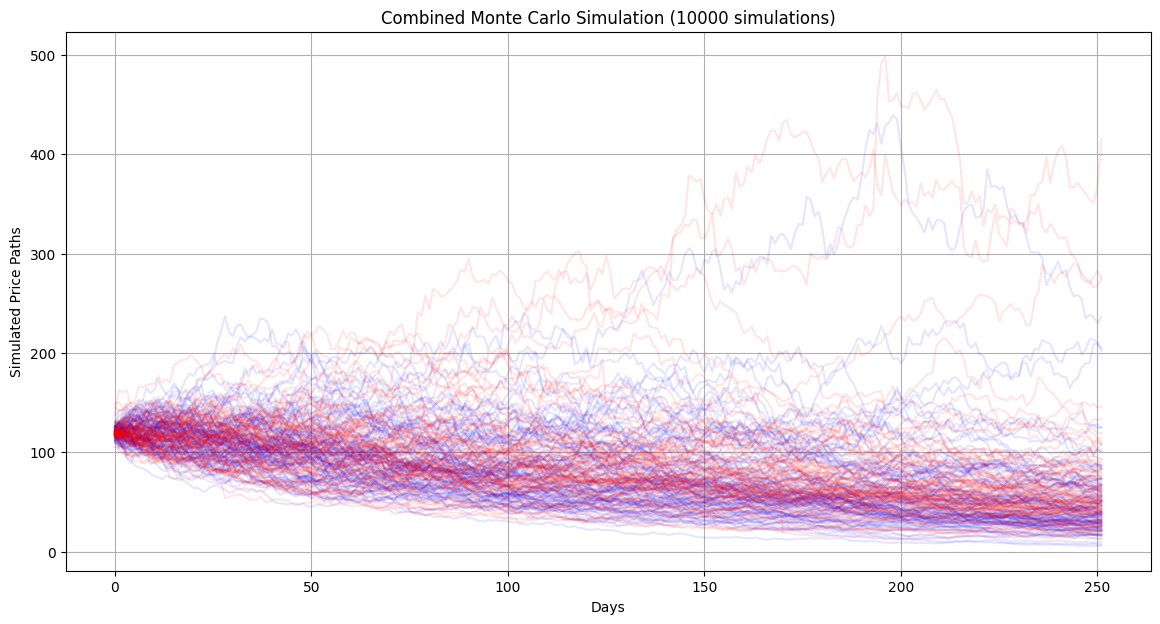

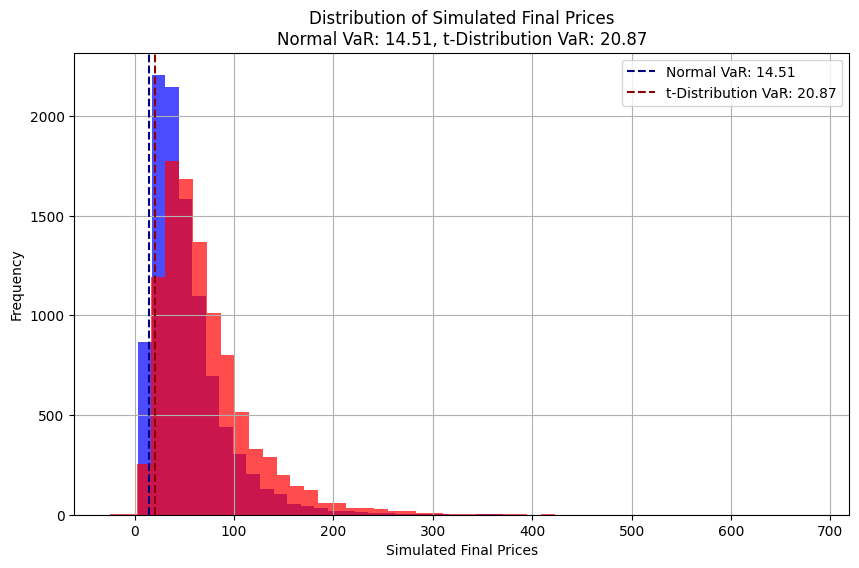

Normal VaR (greatest loss) for META: 1450.80%
Advanced VaR (greatest loss) for META: 2086.76%


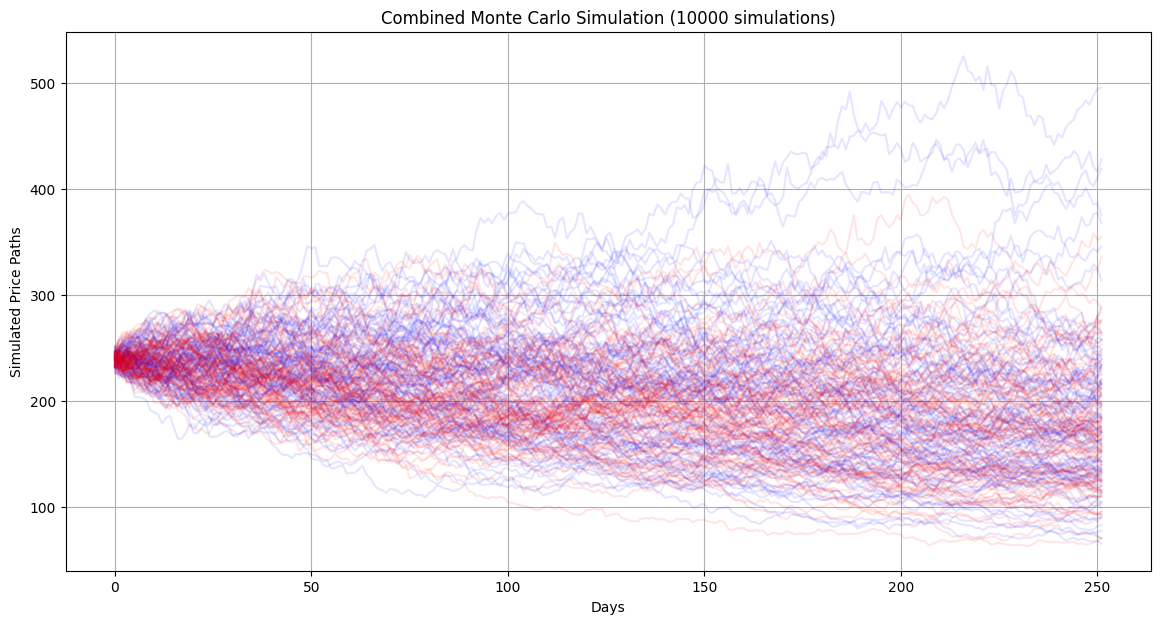

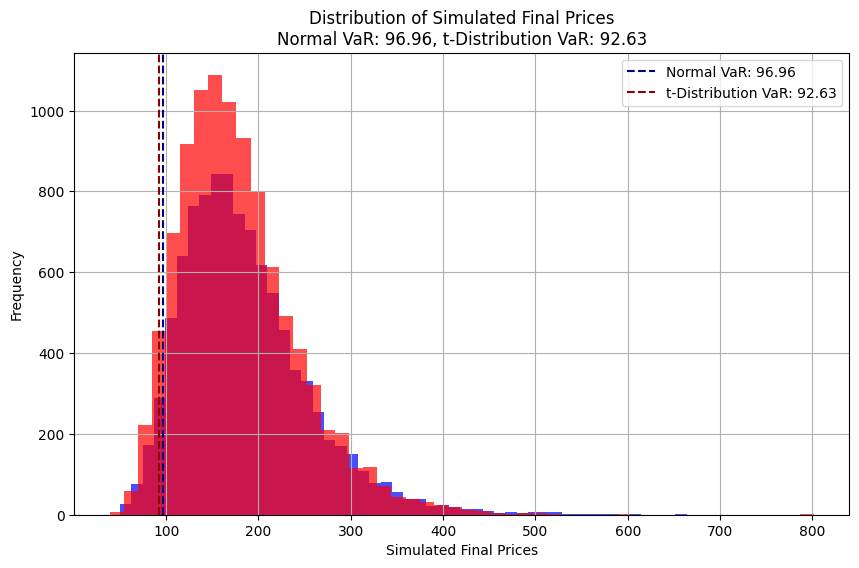

Normal VaR (greatest loss) for MSFT: 9696.10%
Advanced VaR (greatest loss) for MSFT: 9262.70%


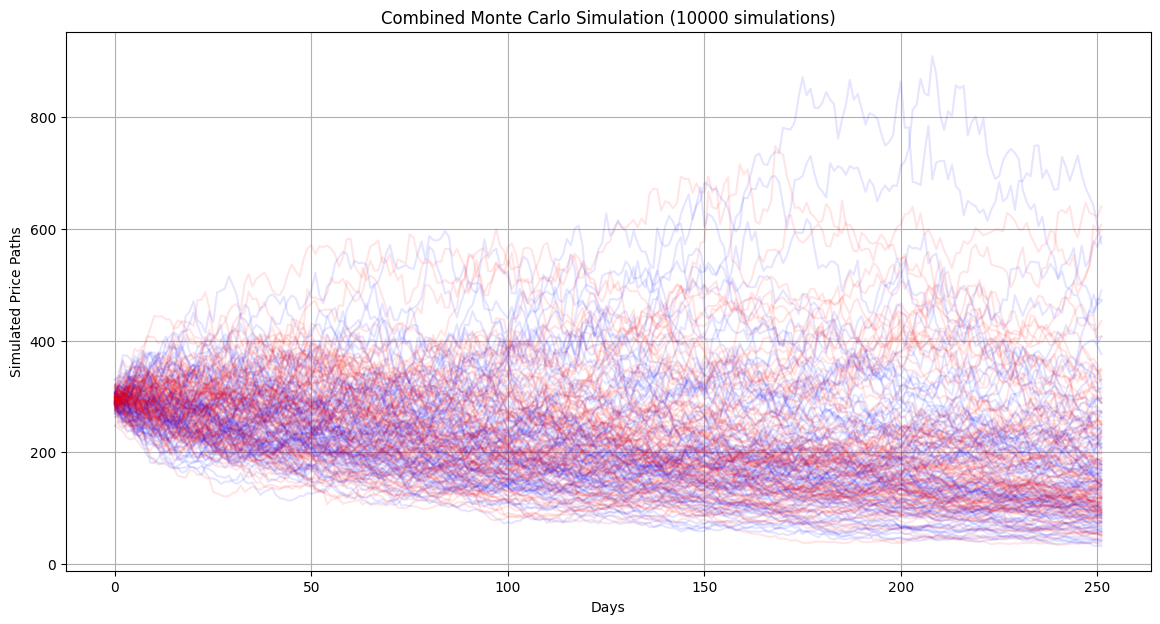

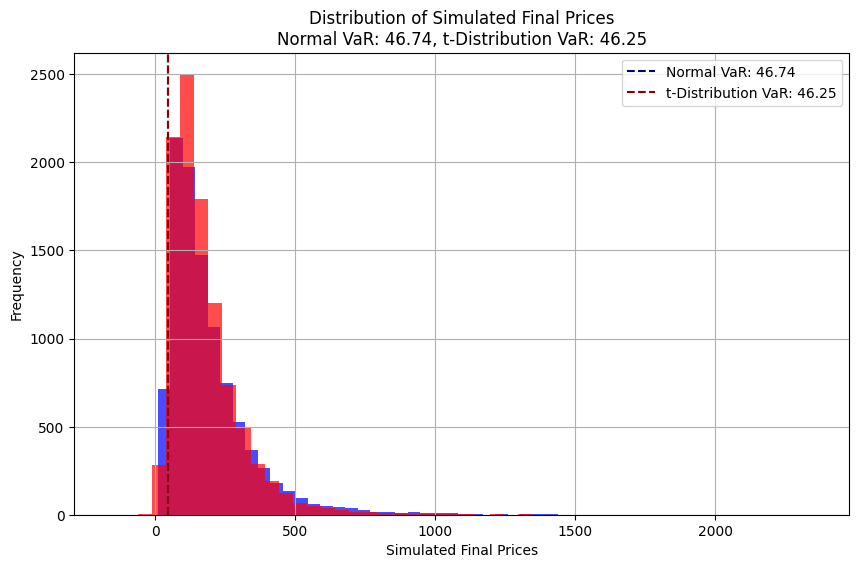

Normal VaR (greatest loss) for NFLX: 4674.39%
Advanced VaR (greatest loss) for NFLX: 4624.55%


In [ ]:
for name, df in zip(sheet_names, dataframes):
    if not df.empty:
        var_normal, var_advanced = combined_monte_carlo_simulation(
            df,
            days=252,
            iterations=10000,
            confidence_level=0.95,
            plot=True,
            plot_subset=100
        )
        print(f"Normal VaR (greatest loss) for {name}: {var_normal*100:.2f}%")
        print(f"Advanced VaR (greatest loss) for {name}: {var_advanced*100:.2f}%")

Portfolio
Asset Allocation

In [ ]:
def plot_distribution(final_returns, VaR, CVaR, confidence_level):
    plt.figure(figsize=(12, 6))
    sns.histplot(final_returns, kde=True, color='blue', bins=50)
    plt.axvline(x=VaR, color='red', linestyle='--', label=f"VaR at {confidence_level*100}%: {VaR:.2f}")
    plt.axvline(x=CVaR, color='green', linestyle='--', label=f"CVaR: {CVaR:.2f}")
    plt.title("Portfolio Return Distribution with VaR and CVaR")
    plt.xlabel("Portfolio Returns")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_monte_carlo_simulation(simulated_portfolio_returns, VaR, CVaR, confidence_level):
    plt.figure(figsize=(14, 7))
    plt.subplot(2, 1, 1)
    colors = sns.color_palette("hsv", len(simulated_portfolio_returns))
    for i in range(len(simulated_portfolio_returns)):
        plt.plot(simulated_portfolio_returns[i, :], color=colors[i], alpha=0.5)
    plt.axhline(y=VaR, color='red', linestyle='--', label=f"VaR at {confidence_level*100}%: {VaR:.2f}")
    plt.axhline(y=CVaR, color='green', linestyle='--', label=f"CVaR: {CVaR:.2f}")
    plt.title(f"Monte Carlo Simulation of Portfolio")
    plt.xlabel('Days')
    plt.ylabel('Simulated Portfolio Returns')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_correlation_heatmap(combined_returns):
    plt.figure(figsize=(8, 6))
    sns.heatmap(combined_returns.corr(), annot=True, cmap='viridis')
    plt.title("Assets Correlation Heatmap")
    plt.show()

In [ ]:
def plot_VaR_impacts(VaR_impact):
    categories = list(VaR_impact.keys())
    impacts = list(VaR_impact.values())

    plt.figure(figsize=(10, 5))
    plt.bar(categories, impacts, color='skyblue')
    plt.xlabel('Analysis Type')
    plt.ylabel('Adjusted VaR')
    plt.title('Impact on VaR by Different Analyses')
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
def calculate_VaR_t_distribution(returns, confidence_level=0.99, iterations=10000):
    # Fit t-distribution to the data
    df, loc, scale = t.fit(returns)
    # Simulate returns
    simulated_returns = t.rvs(df, loc, scale, size=iterations)
    # Calculate VaR
    VaR = np.percentile(simulated_returns, (1 - confidence_level) * 100)
    return VaR

In [ ]:
def calculate_liquidity_risk(dataframes, liquidity_threshold):
    liquidity_risk = {}
    for df, name in zip(dataframes, sheet_names):
        average_volume = df['Volume'].mean()
        liquidity_risk[name] = 'High' if average_volume < liquidity_threshold else 'Low'
    return liquidity_risk

In [ ]:
def stress_test(dataframes, weights, stress_factors):
    stress_results = {}
    for factor, change in stress_factors.items():
        stressed_returns = []
        for df, weight in zip(dataframes, weights):
            stressed_price = df['Close'] * (1 + change)
            stressed_return = stressed_price.pct_change().dropna()
            stressed_returns.append(stressed_return * weight)
        portfolio_stressed_return = pd.concat(stressed_returns, axis=1).sum(axis=1)
        stress_results[factor] = portfolio_stressed_return
    return stress_results

In [ ]:
def conduct_scenario_analysis(dataframes, weights, scenarios):
    scenario_results = {}
    for scenario_name, scenario_changes in scenarios.items():
        scenario_portfolio_returns = pd.DataFrame()
        for df, weight, name in zip(dataframes, weights, sheet_names):
            scenario_df = df.copy()
            for column, change in scenario_changes.items():
                if column in scenario_df.columns:
                    scenario_df[column] *= (1 + change)
            scenario_portfolio_returns[name] = scenario_df[column].pct_change() * weight
        total_scenario_return = scenario_portfolio_returns.sum(axis=1)
        scenario_VaR = np.percentile(total_scenario_return.dropna(), 5)
        scenario_results[scenario_name] = scenario_VaR
    return scenario_results

In [ ]:
def analyze_VaR_impact(dataframes, weights, sheet_names, liquidity_threshold, stress_factors, scenarios, VaR, confidence_level=0.99):
    liquidity_risks = calculate_liquidity_risk(dataframes, liquidity_threshold)
    stress_test_results = stress_test(dataframes, weights, stress_factors)
    scenario_analysis_results = conduct_scenario_analysis(dataframes, weights, scenarios)
    adjusted_VaR = {
        'Liquidity Risk': {},
        'Stress Test': {},
        'Scenario Analysis': {}
    }
    for name, risk in liquidity_risks.items():
        adjusted_VaR['Liquidity Risk'][name] = VaR * 1.1 if risk == 'High' else VaR

    for condition, returns in stress_test_results.items():
        adjusted_VaR['Stress Test'][condition] = calculate_VaR_t_distribution(returns, confidence_level)

    for scenario, returns in scenario_analysis_results.items():
        adjusted_VaR['Scenario Analysis'][scenario] = calculate_VaR_t_distribution(returns, confidence_level)
    flat_adjusted_VaR = {}
    for analysis_type, results in adjusted_VaR.items():
        for name, value in results.items():
            flat_adjusted_VaR[f"{analysis_type} - {name}"] = value

    return flat_adjusted_VaR

In [ ]:
def plot_monte_carlo_portfolio_analysis(dataframes, weights, sheet_names, days=252, iterations=100, confidence_level=0.99):
    combined_returns = pd.DataFrame()
    for df, weight, name in zip(dataframes, weights, sheet_names):
        daily_returns = df['Close'].pct_change().dropna()
        combined_returns[name] = daily_returns * weight

    # Adjust for non-normality of returns
    portfolio_returns = combined_returns.sum(axis=1)
    VaR = calculate_VaR_t_distribution(portfolio_returns, confidence_level, days * iterations)

    # Monte Carlo simulation
    simulated_portfolio_returns = np.zeros((iterations, days))
    for i in range(iterations):
        simulated_portfolio_returns[i, :] = np.cumprod(1 + np.random.normal(portfolio_returns.mean(), portfolio_returns.std(), days))

    final_returns = simulated_portfolio_returns[:, -1]
    CVaR = np.mean(final_returns[final_returns <= VaR])

    # Call the separate plotting functions
    plot_distribution(final_returns, VaR, CVaR, confidence_level)
    plot_monte_carlo_simulation(simulated_portfolio_returns, VaR, CVaR, confidence_level)
    plot_correlation_heatmap(combined_returns)

    VaR_impact = analyze_VaR_impact(dataframes, weights, sheet_names, liquidity_threshold, stress_factors, scenarios, VaR, confidence_level)

    plot_VaR_impacts(VaR_impact)

    return VaR, CVaR, VaR_impact

In [ ]:
liquidity_threshold = 100000
stress_factors = {
    'Market Drop': -0.10,
    'Interest Rate Rise': 0.05
}
scenarios = {
    'Economic Boom': {'Close': 0.1},
    'Market Crash': {'Close': -0.2}
}

{'Economic Boom': -0.044813011513944685, 'Market Crash': -0.044813011513944664}


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


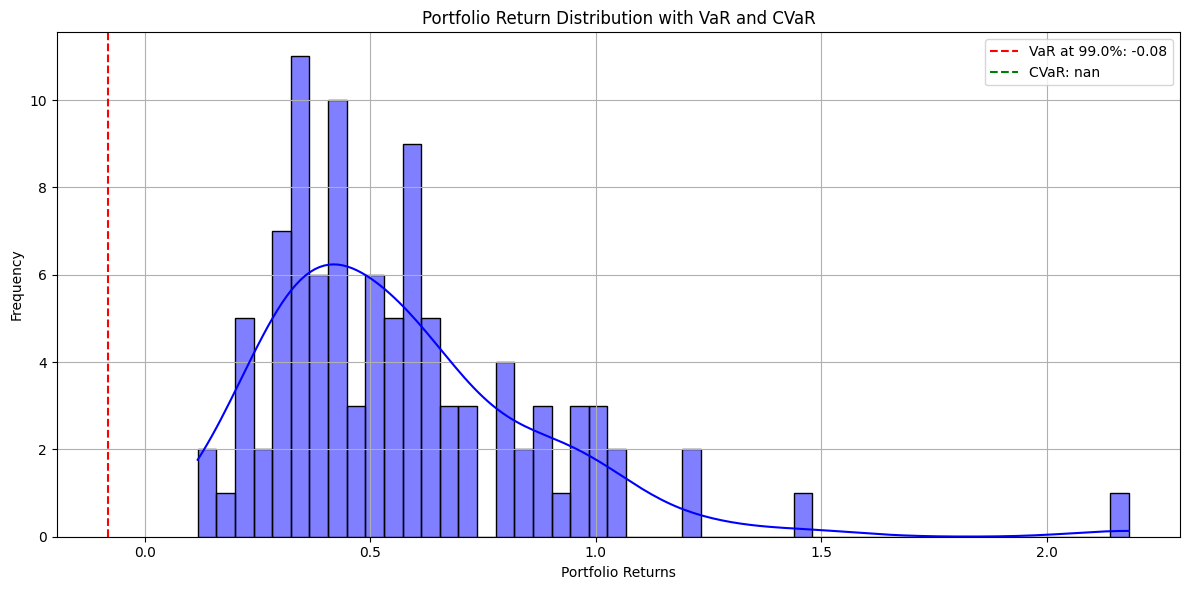

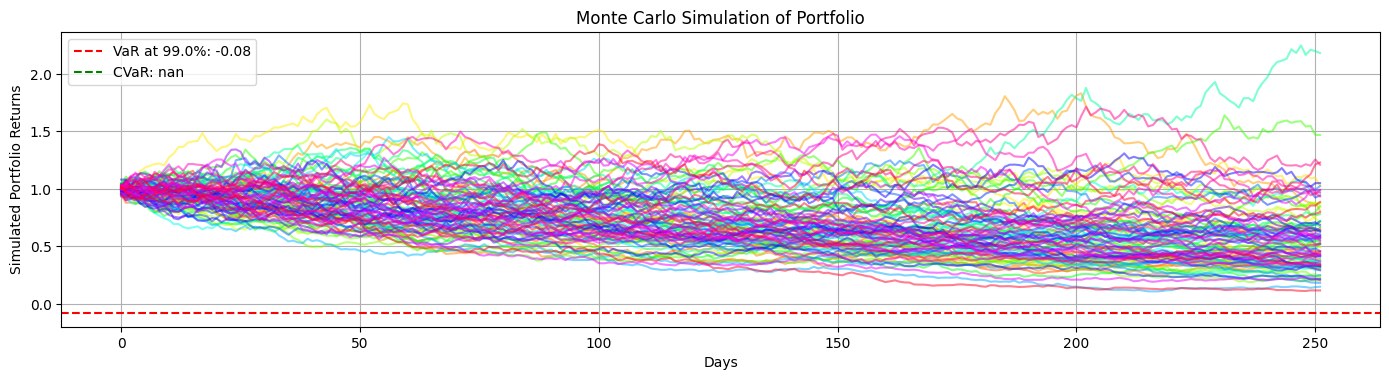

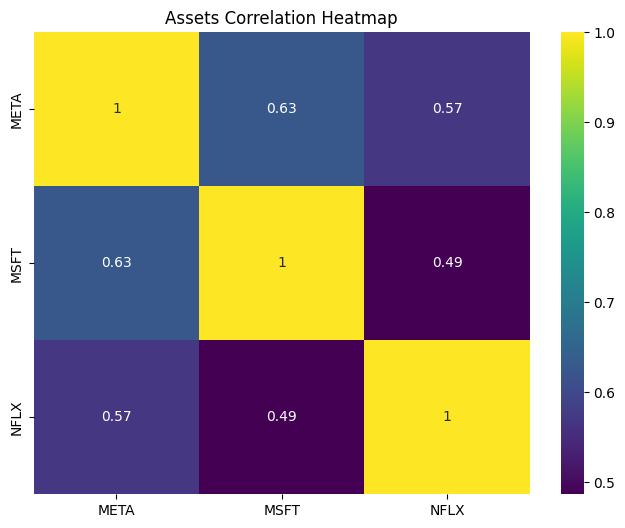

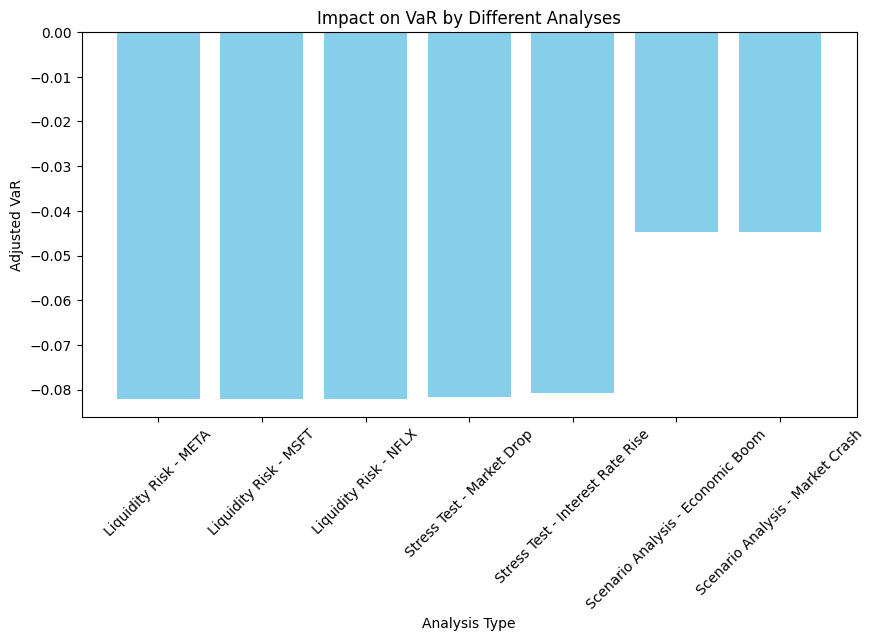

(-0.0820177306252149,
 nan,
 {'Liquidity Risk - META': -0.0820177306252149,
  'Liquidity Risk - MSFT': -0.0820177306252149,
  'Liquidity Risk - NFLX': -0.0820177306252149,
  'Stress Test - Market Drop': -0.08157789506091245,
  'Stress Test - Interest Rate Rise': -0.08064113437134451,
  'Scenario Analysis - Economic Boom': -0.044813011513944706,
  'Scenario Analysis - Market Crash': -0.04481301151394469})

In [ ]:
weights = [1/len(dataframes)] * len(dataframes)
liquidity_threshold = 100000
scenario_results = conduct_scenario_analysis(dataframes, weights, scenarios)

print(scenario_results)
# Call the function to plot the analysis
plot_monte_carlo_portfolio_analysis(dataframes, weights, sheet_names)

In [ ]:
def calculate_portfolio_VaR(weights, dataframes, confidence_level=0.99, scale_factor=10):
    portfolio_returns = pd.DataFrame()

    for weight, df in zip(weights, dataframes):
        returns = df['Close'].pct_change().dropna() * scale_factor
        portfolio_returns = pd.concat([portfolio_returns, returns * weight], axis=1)

    total_returns = portfolio_returns.sum(axis=1)
    df, loc, scale = t.fit(total_returns)
    simulated_returns = t.rvs(df, loc, scale, size=10000)

    simulated_price_changes = np.exp(simulated_returns) - 1
    VaR = np.percentile(simulated_price_changes, (1 - confidence_level) * 100)

    return VaR

In [ ]:
def minimize_VaR(dataframes, sheet_names, confidence_level=0.99, scale_factor=10):
    num_assets = len(dataframes)
    initial_weights = np.array([1.0 / num_assets] * num_assets)

    # Constraints: Weights sum to 1, and each weight is between 0 and 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))

    # Objective function: Minimize VaR
    def objective(weights):
        return calculate_portfolio_VaR(weights, dataframes, confidence_level, scale_factor)

    # Optimization
    result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

    if result.success:
        optimized_weights = result.x
        optimized_VaR = calculate_portfolio_VaR(optimized_weights, dataframes, confidence_level, scale_factor)
        print(f"Optimized Weights: {optimized_weights}")
        print(f"Optimized Portfolio VaR: {optimized_VaR}")
        return optimized_weights, optimized_VaR
    else:
        raise ValueError('Optimization failed')

In [ ]:
optimized_weights, optimized_VaR = minimize_VaR(dataframes, sheet_names)

Optimized Weights: [0.33300782 0.33300782 0.33398436]
Optimized Portfolio VaR: -0.5435439772140237


ML

OPtimize / Tuning Parameters